# Experiment

In [1]:
%load_ext autoreload
%autoreload 2

Beware, this will result in, where we always save the `pipeline`, to be able to do restarts.
<pre>
    0:01 <span style="color:#42A5F5">  71K</span> S37_detector_data_slices.png
    0:01 <span style="color:#42A5F5"> 110K</span> S37_detector_data_sum.png
    0:01 <span style="color:#42A5F5"> 144K</span> S37_detector_data_orthogonalisation.png
    0:01 <span style="color:#FF7043"> 1.6G</span> S37_preprocessed_data.cxi
    0:01 <span style="color:#42A5F5"> 3.3K</span> preprocess_output.log
    0:12 <span style="color:#42A5F5">  53K</span> phase_retrieval_output.log
    0:15 <span style="color:#FF7043"> 9.6G</span> pynx_phasing/
    0:37 <span style="color:#B0B0B0">    0</span> mode_decomposition_output.log
    0:38 <span style="color:#FFA726"> 736M</span> S37_pynx_reconstruction_mode.cxi
    0:38 <span style="color:#B0B0B0">    0</span> postprocess_output.log
    0:39 <span style="color:#42A5F5">  78K</span> S37_amplitude_distribution.png
    0:39 <span style="color:#42A5F5"> 156K</span> S37_summary_plot.png
    0:39 <span style="color:#42A5F5"> 102K</span> S37_strain_methods.png
    0:39 <span style="color:#42A5F5">  88K</span> S37_shear_displacement.png
    0:39 <span style="color:#42A5F5"> 132K</span> S37_strain_statistics.png
    0:39 <span style="color:#42A5F5"> 203K</span> S37_3d_strain_views.png
    0:39 <span style="color:#42A5F5"> 158K</span> S37_final_object_fft.png
    0:39 <span style="color:#FFA726"> 869M</span> S37_postprocessed_data.cxi
    0:39 <span style="color:#66BB6A">  74M</span> S37_structural_properties.npz
    0:39 <span style="color:#66BB6A">  90M</span> S37_structural_properties.vti
    0:39 <span style="color:#42A5F5"> 2.3K</span> S37_parameters.yml
    0:39 <span style="color:#D32F2F">  17G</span> <b>pipeline.pkl</b>
</pre>

Thus, do not hoard computations for this part, as it is mostly a useless proof of concept for splitting random codes.

In [2]:
import facets_drivers
import os
user = os.environ.get('USER')

notebook_data = {
    "num_cores": 16,
    "experiment_directory": f"/data/id01/inhouse/{user}/scratch/ewoks_01_experiment/",  # last '/' important for cdiutil’s postprocess
    "experimental_structure": f"/data/id01/inhouse/{user}/scratch/ewoks_01_experiment/S37_structural_properties.vti",
    "theory_directory": f"/data/id01/inhouse/{user}/scratch/ewoks_02_theory/",
    "simulation_directory": f"/data/id01/inhouse/{user}/scratch/ewoks_03_simulation/",
    "facets_directory": f"/data/id01/inhouse/{user}/scratch/ewoks_04_facets/",
}
%store notebook_data

globals().update(notebook_data)

Stored 'notebook_data' (dict)


In [3]:
import os

simulation_parameters = {
    # metadata
    "beamline_setup": "p10",
    "experiment_data_dir_path": (
        "/data/projects/carine/Experiments/P10_June24/raw/"
    ),
    "sample_name": "Pd_YSZ",  
    "scan": 37,
    
    # preprocessing parameters
    "preprocess_shape": (600, 400, 400),  # define cropped window size
    "voxel_reference_methods": [(300, 1326, 1489)],  # centring method sequence
    "background_level": 2,  # background intensity level to remove
    "hot_pixel_filter": True,  # remove isolated hot pixels
    "light_loading": True,
    "det_calib_params": {
        'distance': 1.82169,        # Sample-detector distance in meters
        'cch1': 1055.74,            # Direct beam position on detector (vert. pixel)
        'cch2': 1332.94,            # Direct beam position on detector (hor. pixel)
        'pwidth1': 7.5e-05,
        'pwidth2': 7.5e-05,  
    }
}

In [4]:
from ewoks import execute_graph

# or use default_inputs
nodes = [
    {
        "id": "init_pipeline",
        "task_type": "class",
        "task_identifier": "facets_drivers.experiment.InitBcdiPipeline",
    },
    {
        "id": "preprocess",
        "task_type": "class",
        "task_identifier": "facets_drivers.experiment.BcdiPreprocess",
    },
    {
        "id": "phase_retrieval",
        "task_type": "class",
        "task_identifier": "facets_drivers.experiment.PhaseRetrieval",
    },
    {
        "id": "phase_analysis",
        "task_type": "class",
        "task_identifier": "facets_drivers.experiment.PhaseAnalysis",
    },
    {
        "id": "select_best",
        "task_type": "class",
        "task_identifier": "facets_drivers.experiment.SelectingBest",
    },
    {
        "id": "mode_decompose",
        "task_type": "class",
        "task_identifier": "facets_drivers.experiment.ModeDecomposition",
    },
    {
        "id": "postprocess",
        "task_type": "class",
        "task_identifier": "facets_drivers.experiment.PostProcess",
    },
]

links = [
    {
        "source": "init_pipeline",
        "target": "preprocess",
        "data_mapping": [{"source_output": "pipeline", "target_input": "pipeline"},
                         {"source_output": "scratch_directory", "target_input": "scratch_directory"}],
    },
    {
        "source": "preprocess",
        "target": "phase_retrieval",
        "data_mapping": [{"source_output": "pipeline", "target_input": "pipeline"},
                         {"source_output": "scratch_directory", "target_input": "scratch_directory"}],
    },
    {
        "source": "phase_retrieval",
        "target": "phase_analysis",
        "data_mapping": [{"source_output": "pipeline", "target_input": "pipeline"},
                         {"source_output": "scratch_directory", "target_input": "scratch_directory"}],
    },
    {
        "source": "phase_analysis",
        "target": "select_best",
        "data_mapping": [{"source_output": "pipeline", "target_input": "pipeline"},
                         {"source_output": "scratch_directory", "target_input": "scratch_directory"}],
    },
    {
        "source": "select_best",
        "target": "mode_decompose",
        "data_mapping": [{"source_output": "pipeline", "target_input": "pipeline"},
                         {"source_output": "scratch_directory", "target_input": "scratch_directory"}],
    },
    {
        "source": "mode_decompose",
        "target": "postprocess",
        "data_mapping": [{"source_output": "pipeline", "target_input": "pipeline"},
                         {"source_output": "scratch_directory", "target_input": "scratch_directory"}],
    },
]

workflow = {"graph": {"id": "experiment"}, "nodes": nodes, "links": links}

inputs = [
    {"id": "init_pipeline", "name": "parameters", "value": simulation_parameters},
    {"id": "init_pipeline", "name": "scratch_directory", "value": experiment_directory},
]

[INFO] BcdiPipeline initialised.



Dump directory already exists, results will be saved in:
/data/id01/inhouse/polack/scratch/ewoks_01_experiment/.


[INFO] 
*******************************************************************************
*                        Starting process: preprocess                         *
*******************************************************************************

[INFO] 
Shape already in agreement with pynx shape conventions.

[INFO] 
Light loading requested, will use ROI [0, 600, 1126, 1526, 1289, 1689] and bin along rocking curve direction by None during data loading.
[INFO] Energy successfully loaded (10574.286342558808 eV).
[INFO] hot_pixel_filter requested.
[INFO] Will use defaults parameters: threshold = 1e2, kernel_size = 3 
[INFO] background_level set to 2, will remove the background.
[INFO] 
Oversampling ratios calculated from diffraction pattern are: axis0: 2.2, axis1: 8.0, axis2: 5.3. If low-strain crystal, you can set PyNX 'rebin' parameter to (1.0, 4.0, 2.0)
[INFO] 
Summary table:
╒═════════╤═════════════════════╤═══════════════════╤════════════════╤═════════════════╕
│ voxel   │ uncrop.

[INFO] Computing metrics...
[INFO] the sorted list of runs using 'mean_to_max' sorting_criterion is:
['01', '08', '06', '10', '05', '02', '03', '09', '07', '04'].
[INFO] Plotting phasing results...
[INFO] Best candidates selected:
['01', '08', '06']


[INFO] 
*******************************************************************************
*                    Starting process: mode_decomposition                     *
*******************************************************************************

[INFO] 
R_match(1) = 10.365 %

[INFO] 
R_match(2) = 13.794 %

[INFO] 
First mode represents 99.485 %

[INFO] Process mode_decomposition completed successfully.
[INFO] 
*******************************************************************************
*                        Starting process: postprocess                        *
*******************************************************************************

[INFO] Additional parameters provided {'isosurface': 0.3, 'voxel_size': None, 'flip': False}, will update the current dictionary of parameters.
[INFO] The oversampling ratios in each direction (original frame) are axis0: 3.3, axis1: 10.8, axis2: 7.7
[INFO] Voxel size finally used is: (2.175637070751176, 7.395487763884197, 7.123145197125108)

{'pipeline': <cdiutils.pipeline.bcdi.BcdiPipeline object at 0x14788f205ab0>, 'scratch_directory': '/data/id01/inhouse/polack/scratch/ewoks_01_experiment/'}


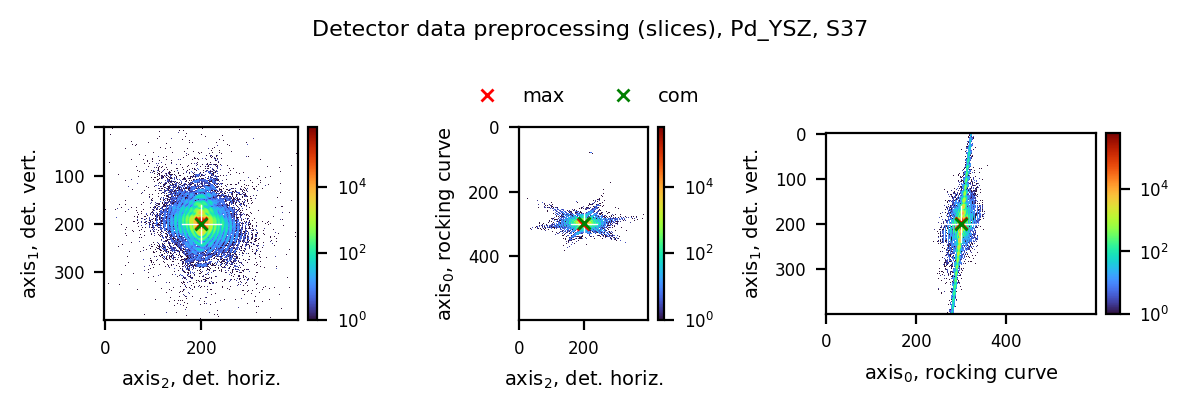

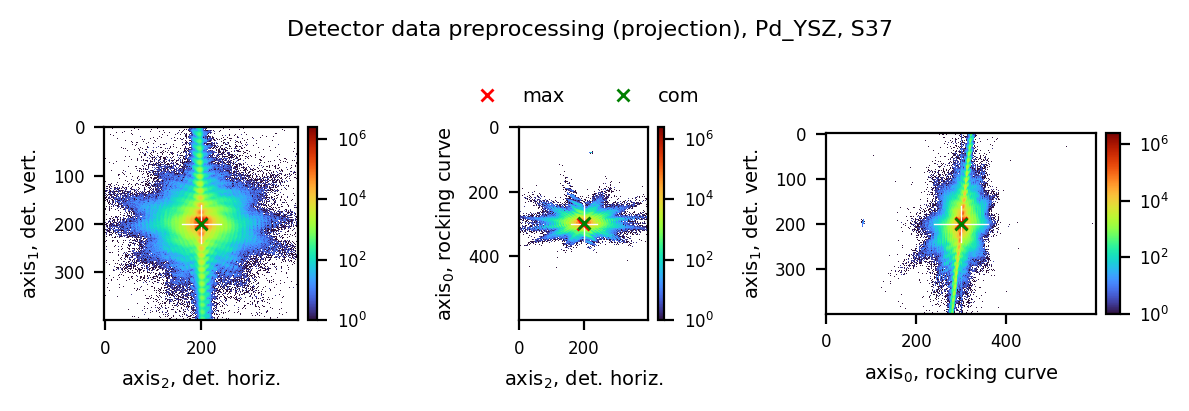

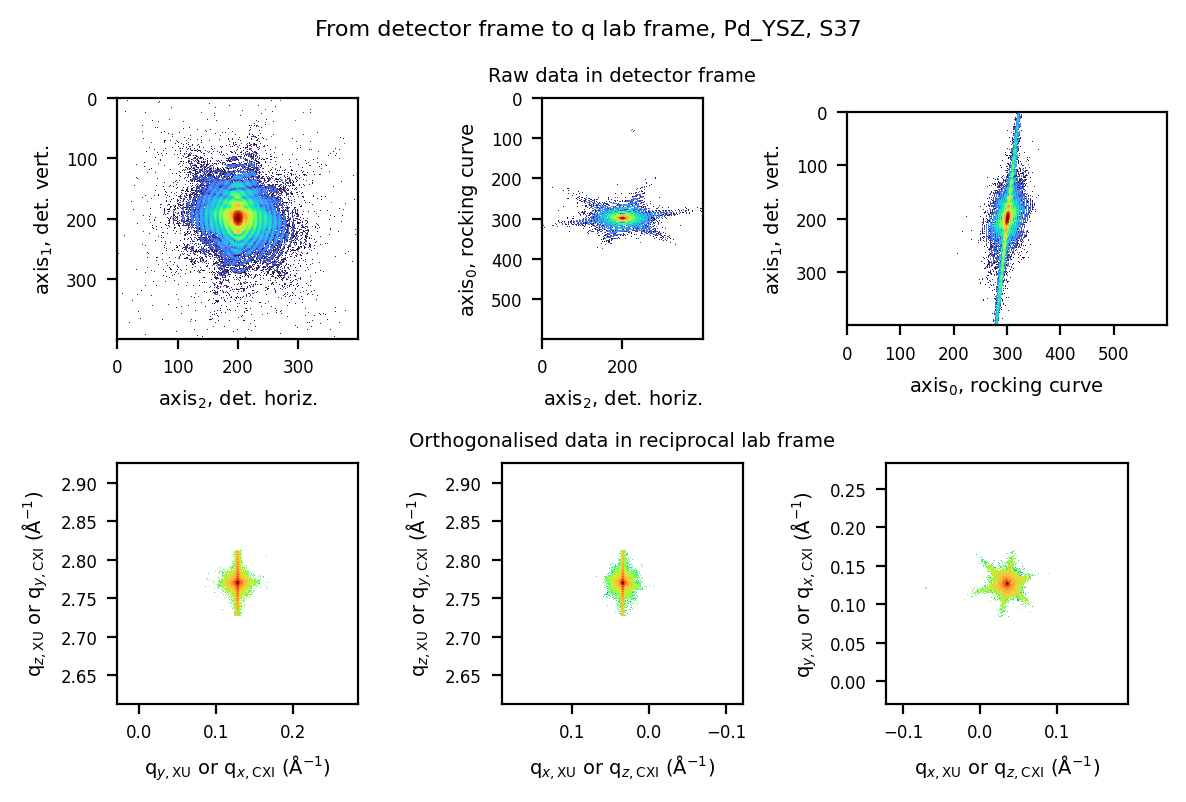

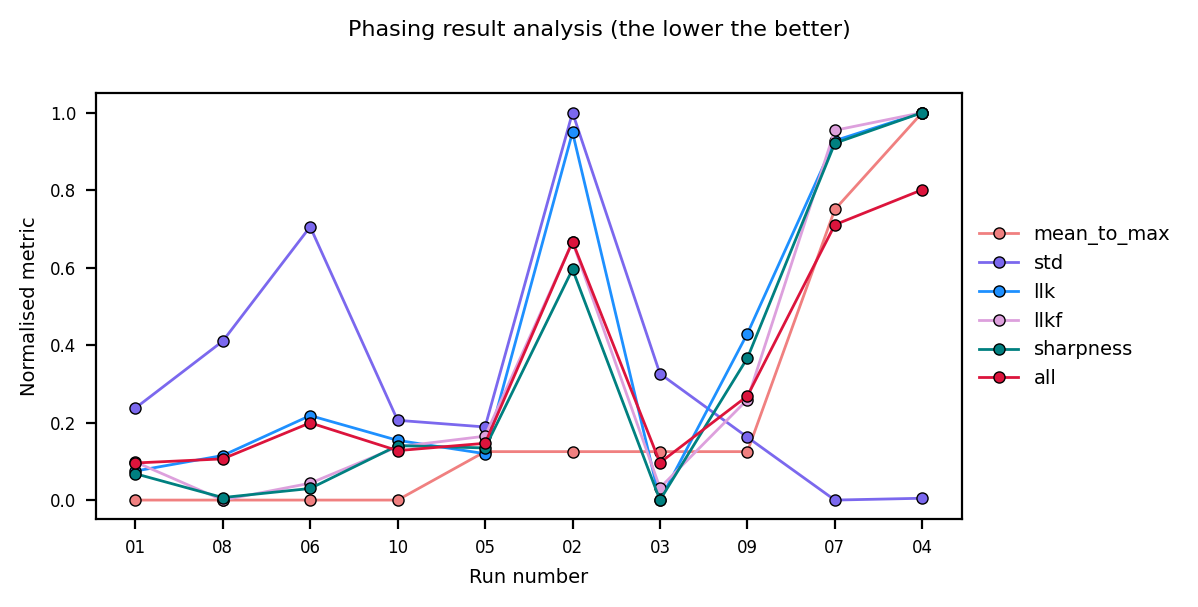

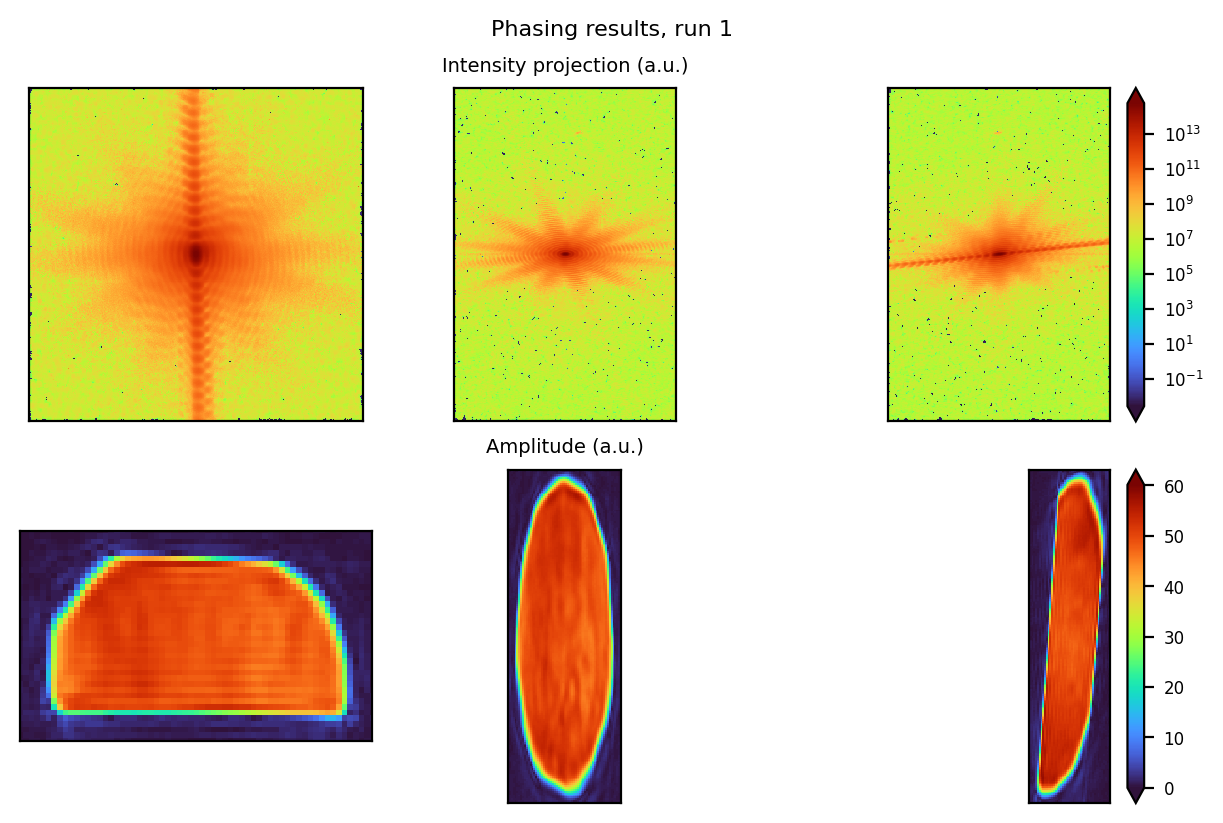

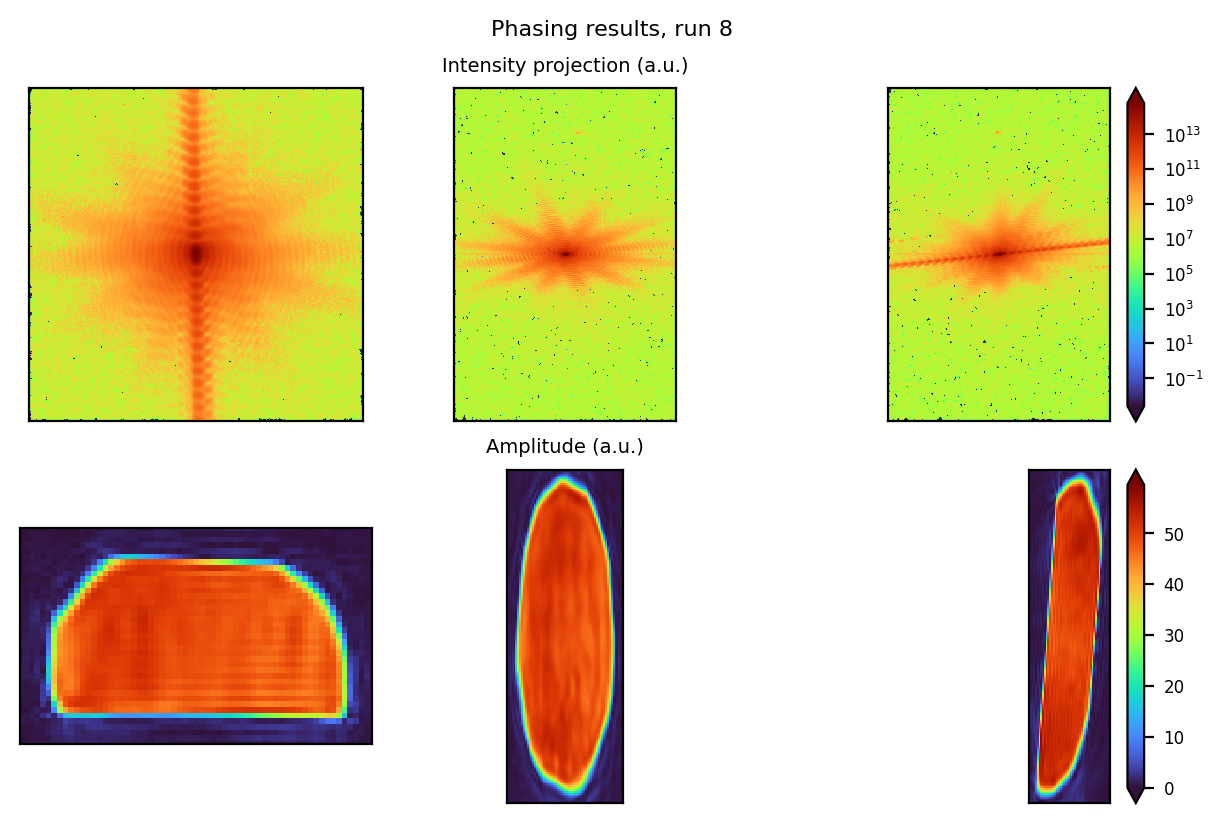

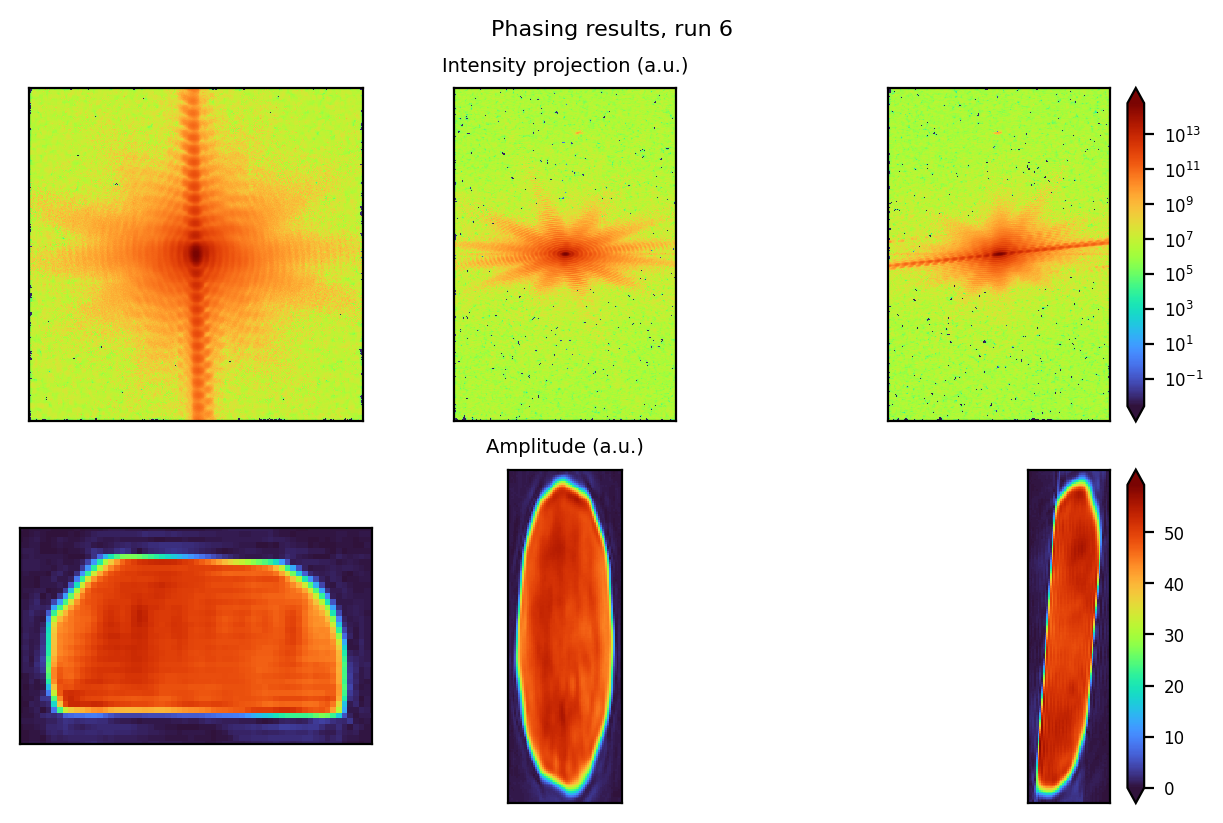

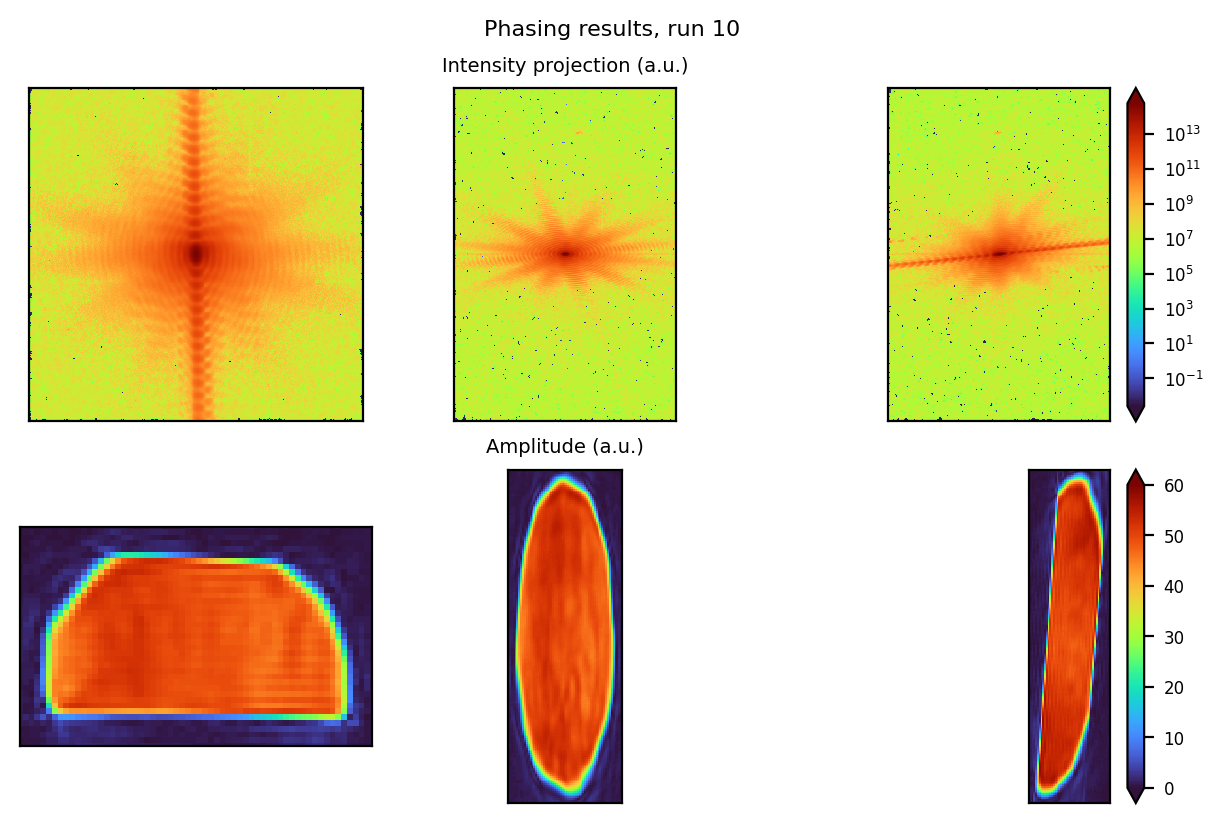

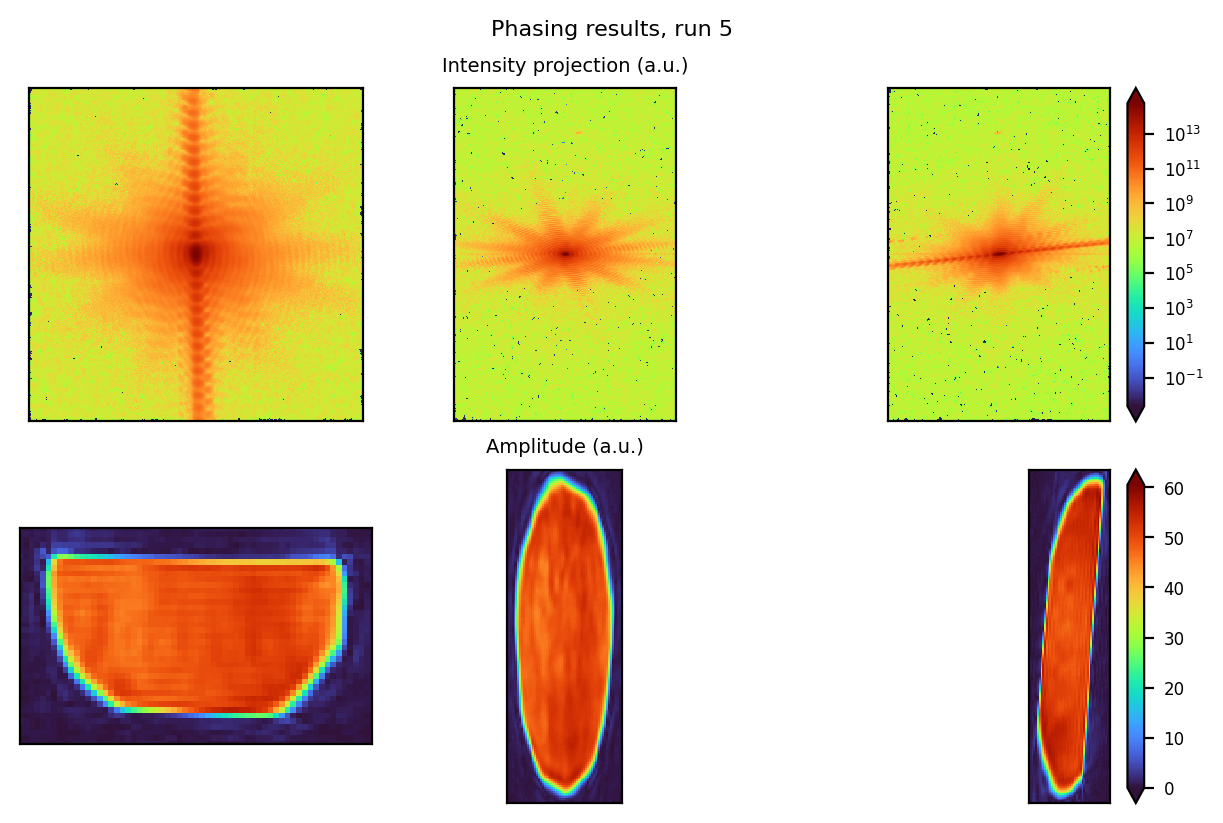

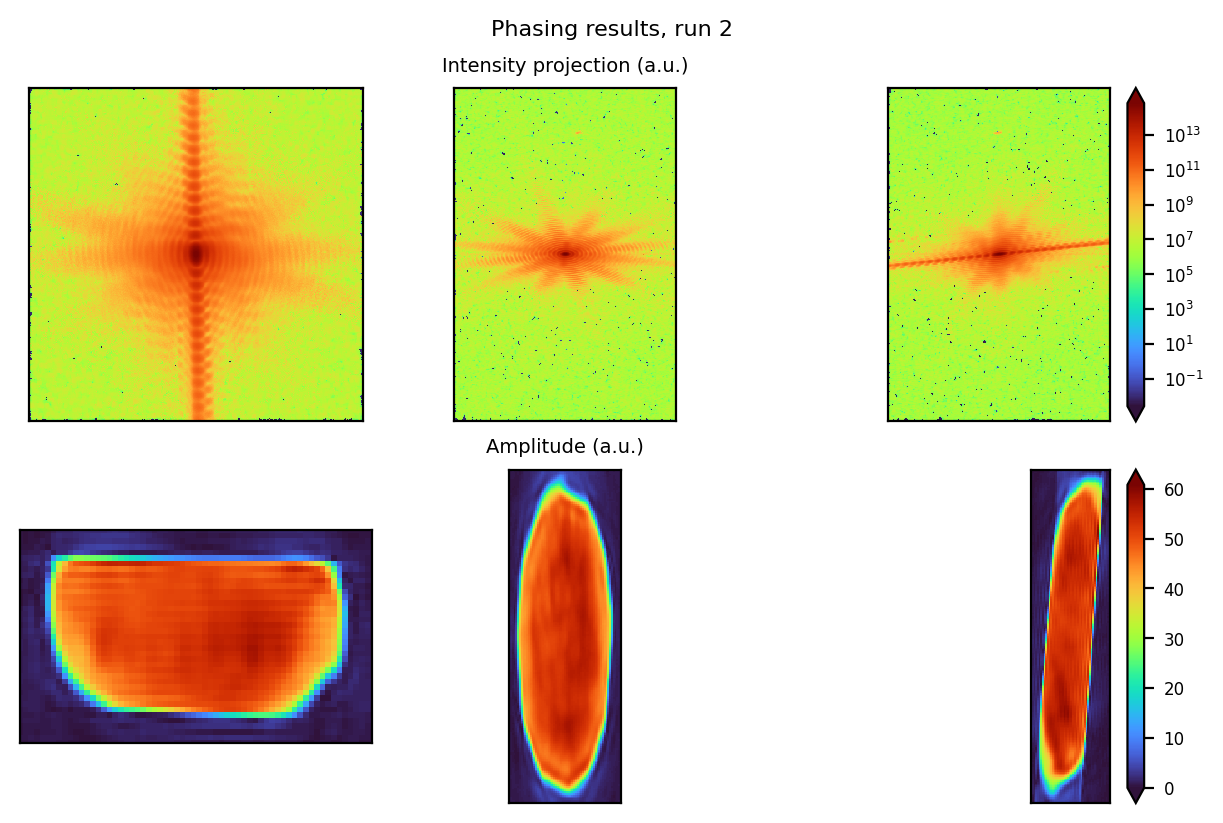

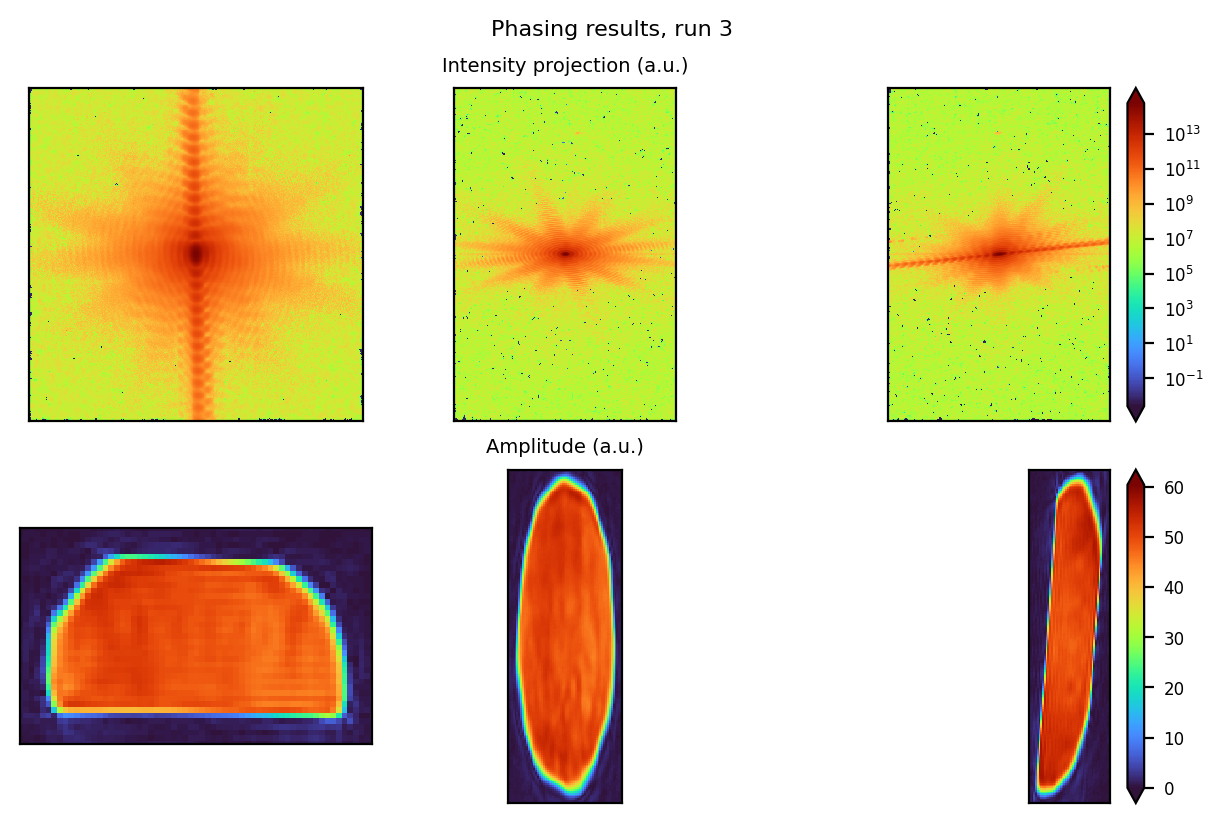

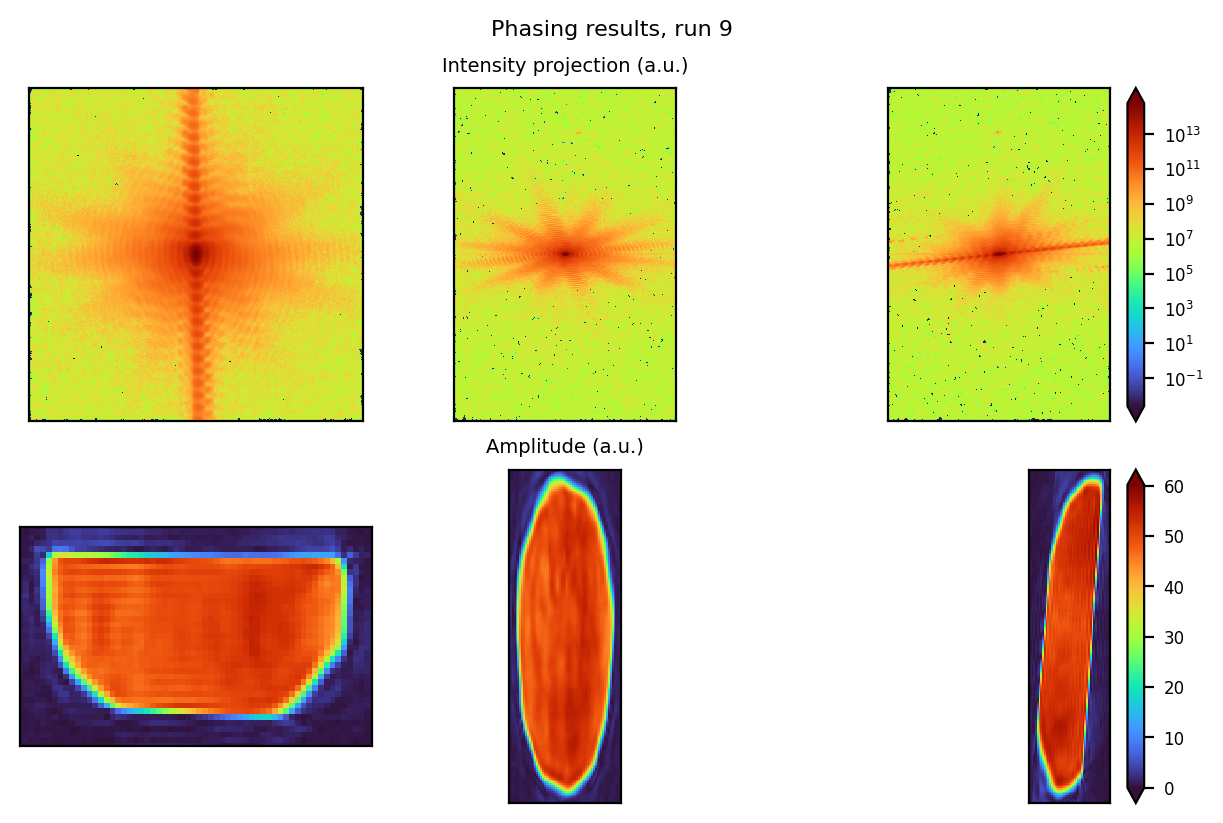

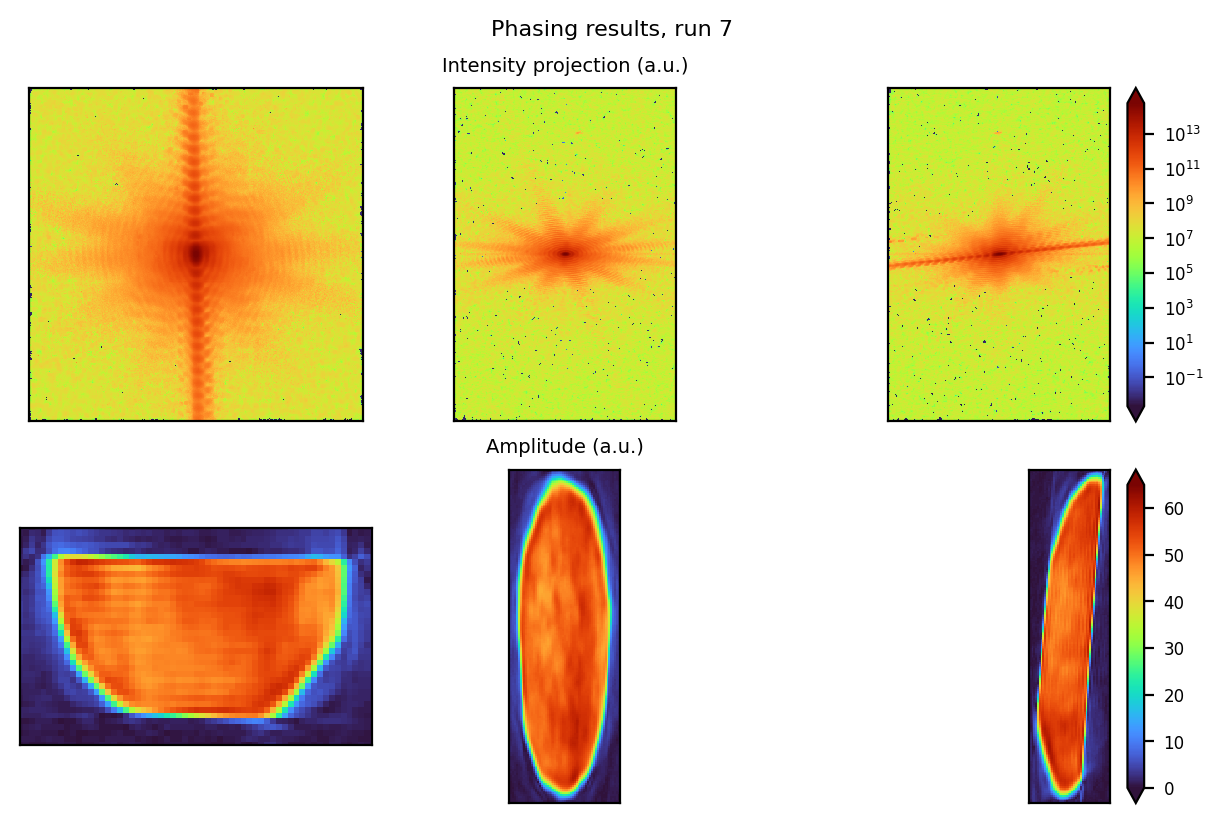

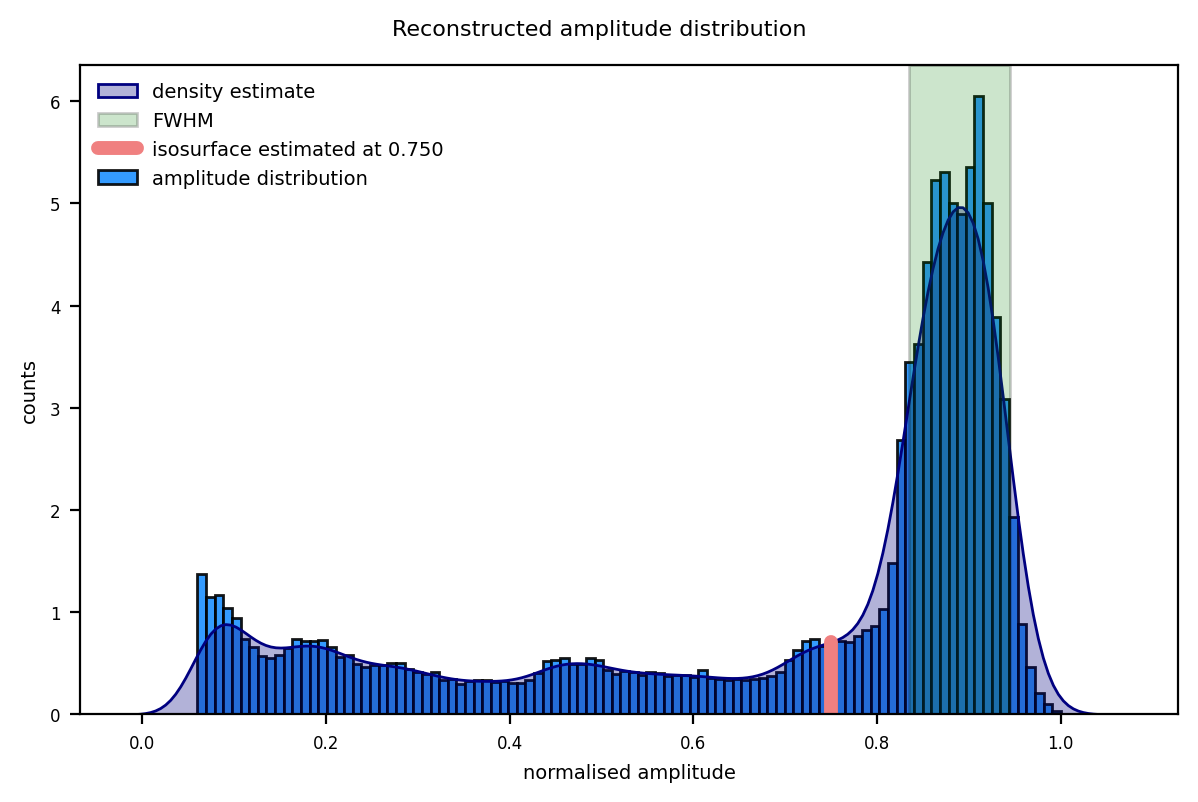

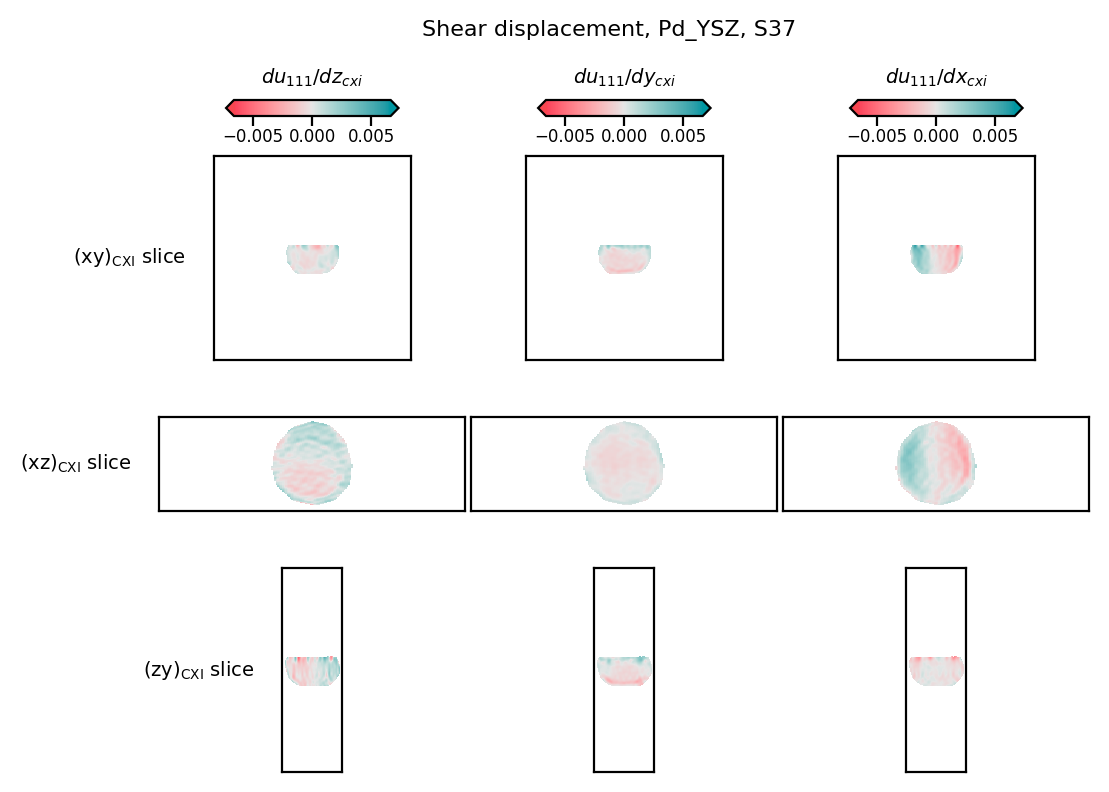

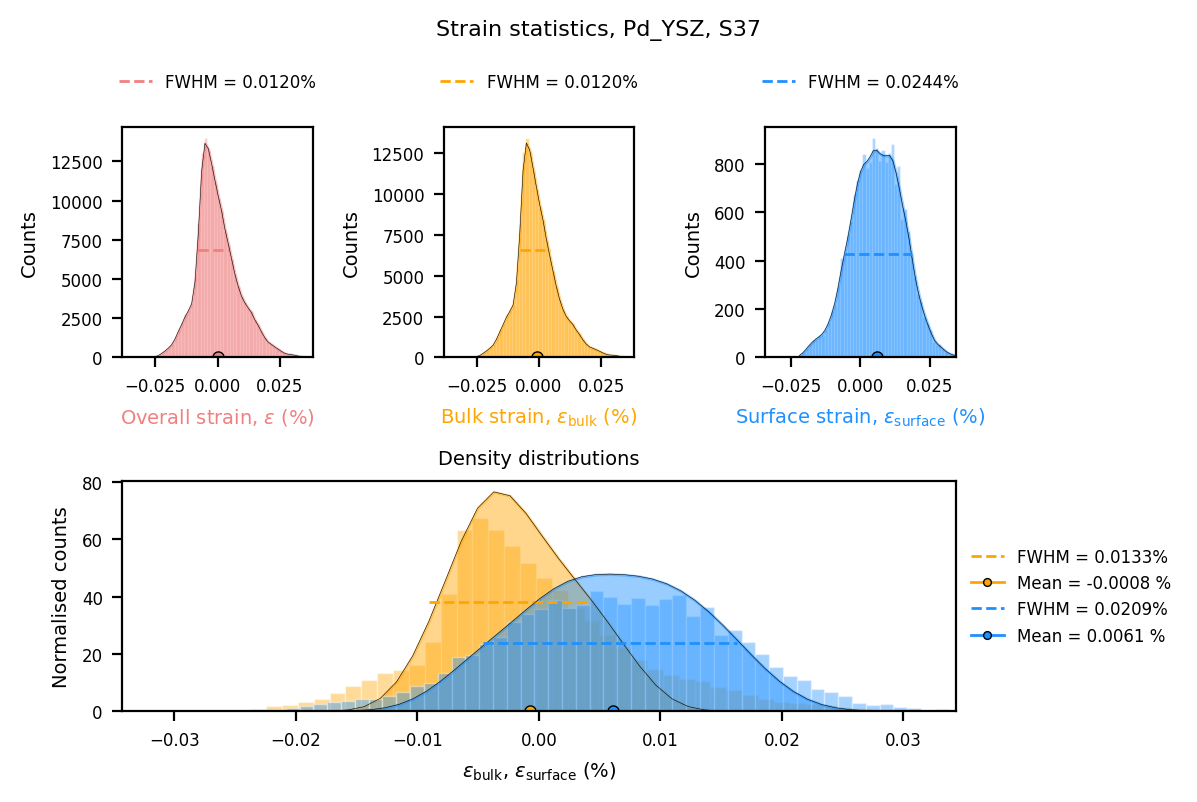

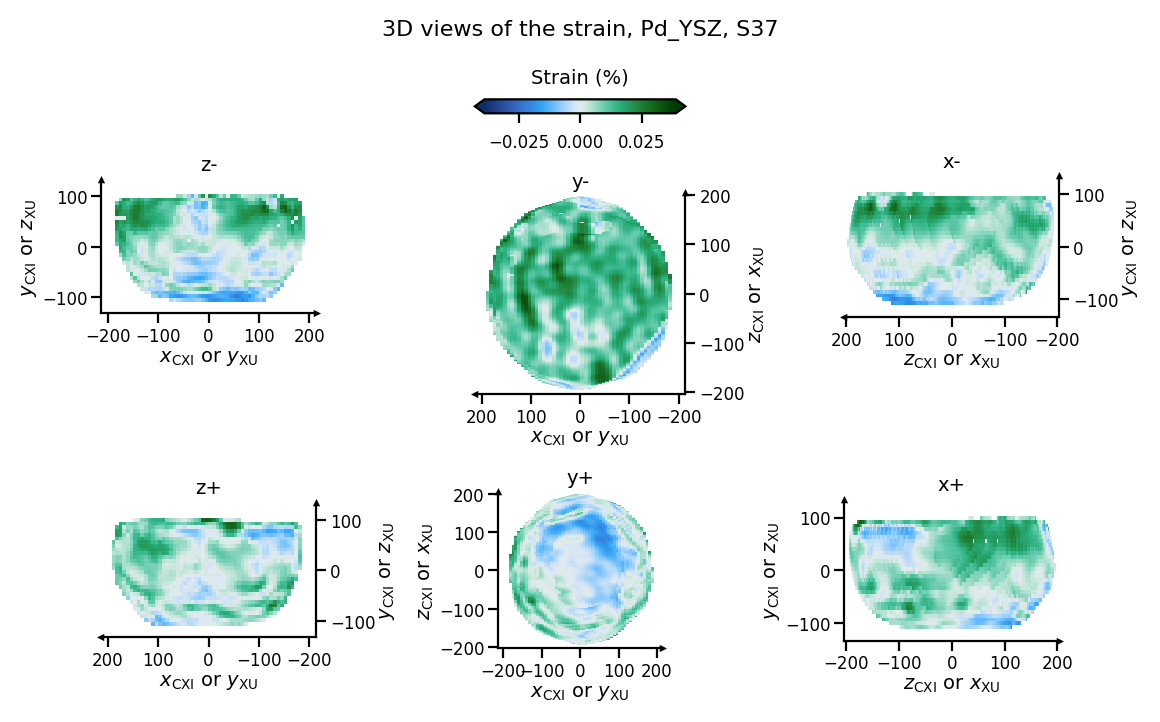

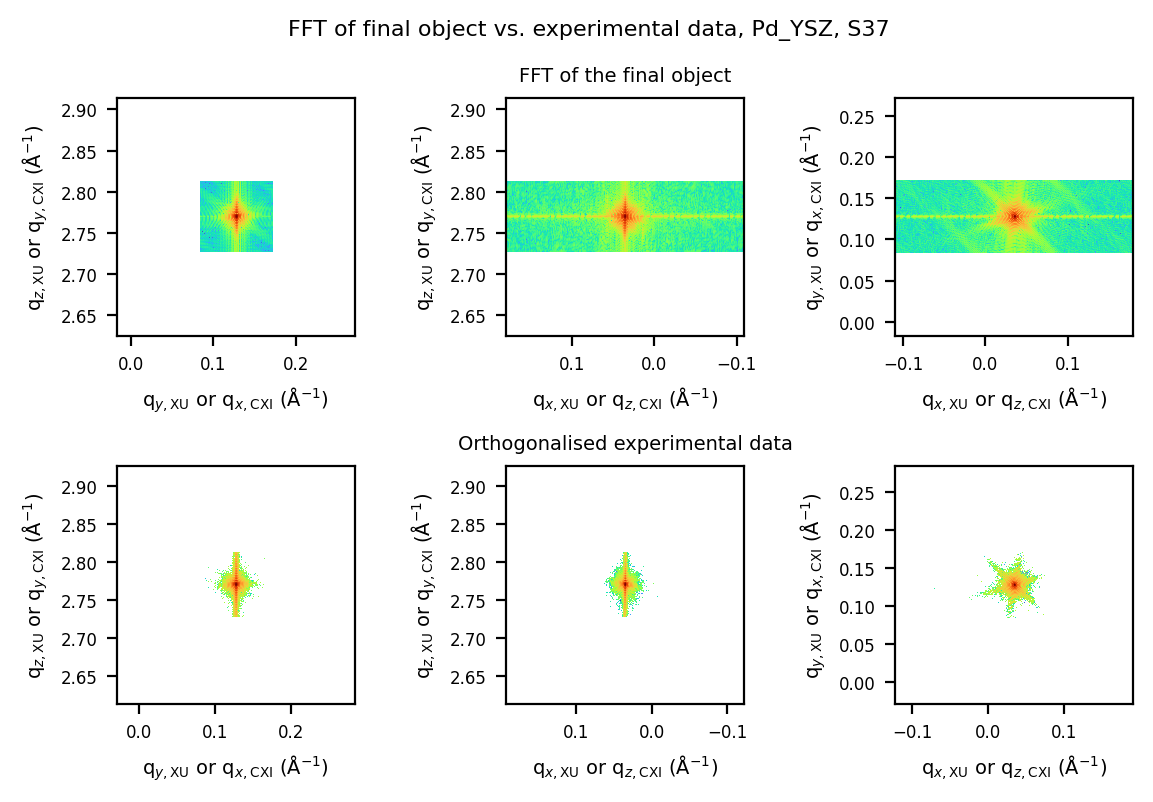

In [5]:
result = execute_graph(workflow, inputs=inputs)
print(result)

## Simulating restart

In [6]:
restarted_workflow = {
    "graph": {"id": "restarted_workflow"},
    "nodes": workflow["nodes"][5:],
    "links": workflow["links"][5:]
}

restart = facets_drivers.experiment.pickle_to_rick(os.path.join(experiment_directory, "pipeline.pkl"))
restarted_inputs = [
    {"id": "mode_decompose", "name": "pipeline", "value": restart},
    {"id": "mode_decompose", "name": "scratch_directory", "value": experiment_directory},
]